# Testing

In [1]:
include("utils.jl"); using .Utils
checkpkgs("Distributions", "Plots", "DataStructures", "DataFrames", "Statistics", "Loess")

## Estimation

In [2]:
include("empiricaldist.jl"); using .EmpiricalDist

xs = range(0, 1, length=101)
uniform = Pmf(1, xs);

In [3]:
using Distributions

k, n = 140, 250
likelihood = pdf.(Binomial.(n, xs), k);

In [4]:
posterior = uniform .* likelihood
normalize!(posterior)

0.3984063745019944

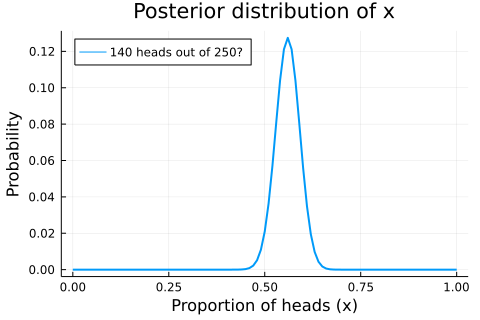

In [5]:
using Plots
plot(posterior, label="140 heads out of 250?", legend=:topleft)

xlabel!("Proportion of heads (x)")
ylabel!("Probability")
title!("Posterior distribution of x")

In [6]:
println(mean(posterior), " ",
        credibleinterval(posterior, 0.9))

0.5595238095238095 [0.51, 0.61]


## Evidence

In [7]:
k = 140
n = 250

like_fair = pdf(Binomial(n, 0.5), k)
like_fair

0.00835718172491837

In [8]:
like_biased = pdf(Binomial(n, 0.56), k)
like_biased

0.050778159595184454

In [9]:
K = like_biased / like_fair
K

6.075990838368473

## Uniformly Distributed Bias

In [10]:
biased_uniform = copy(uniform)
biased_uniform[0.5] = 0
normalize!(biased_uniform)

100.0

In [11]:
xs = biased_uniform.qs
likelihood = pdf.(Binomial.(n, xs), k);

In [12]:
like_uniform = sum(biased_uniform .* likelihood)
like_uniform

0.0039004919277707602

In [13]:
K = like_fair / like_uniform
K

2.1425968518013914

In [14]:
prior_odds = 1
posterior_odds = prior_odds .* K
posterior_odds

2.1425968518013914

In [15]:
prob(o) = o / (o+1)

prob (generic function with 1 method)

In [16]:
posterior_probability = prob(posterior_odds)
posterior_probability

0.681791827855112

In [17]:
ramp_up = 0:49
ramp_down = 50:-1:0
a = vcat(ramp_up, ramp_down)

triangle = Pmf(a, xs, name="triangle")
normalize!(triangle)

2500.0

In [18]:
biased_triangle = copy(triangle)
biased_triangle[0.5] = 0
normalize!(biased_triangle)

0.98

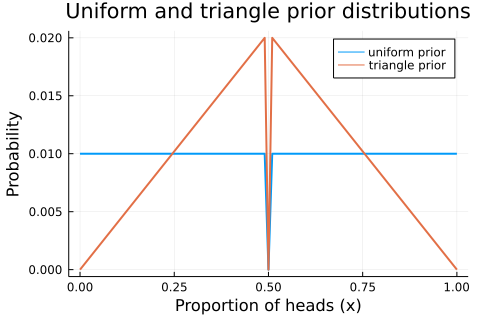

In [19]:
plot(biased_uniform, label="uniform prior")
plot!(biased_triangle, label="triangle prior")

xlabel!("Proportion of heads (x)")
ylabel!("Probability")
title!("Uniform and triangle prior distributions")

In [20]:
like_triangle = sum(biased_triangle .* likelihood)
like_triangle

0.006981325464857927

In [21]:
K = like_fair / like_triangle
K

1.1970766535647313

## Bayesian Hypothesis Testing

## Bayesian Bandits

## Prior Beliefs

In [22]:
xs = range(0, 1, length=101)
prior = Pmf(1, xs)
normalize!(prior)

101.0

In [23]:
beliefs = [copy(prior) for i ∈ 1:4];

In [24]:
function plot_beliefs(beliefs; kwargs...)
    l = @layout grid(2,2)
    xlabels = fill("", 4)
    ylabels = fill("", 4)
    for i=[1, 3]
        ylabels[i] = "PDF"
    end
    for i=[3, 4]
        xlabels[i]="Probability of winning"
    end
    v = Vector{Any}(undef, 4)
    plot!(legendfontsize=5)
    for i=1:4
        v[i] = plot(beliefs[i], label="Machine $i", xlabel=xlabels[i], ylabel=ylabels[i]; kwargs...)
    end
    plot(v..., layout=l)
end

plot_beliefs (generic function with 1 method)

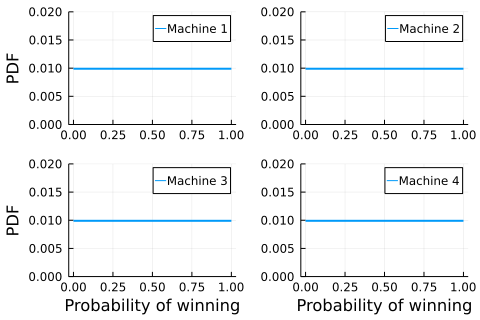

In [25]:
plot_beliefs(beliefs, ylims=(0, 0.02))

## The Update

In [26]:
likelihood = Dict(
    'W' => xs,
    'L' => 1 .- xs
)

Dict{Char, StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}}} with 2 entries:
  'L' => 1.0:-0.01:0.0
  'W' => 0.0:0.01:1.0

In [27]:
"""Update the probability of winning."""
function update!(pmf, data)
    pmf .*= likelihood[data]
    normalize!(pmf)
end

update!

In [28]:
bandit = copy(prior)

for outcome in "WLLLLLLLLL"
    update!(bandit, outcome)
end

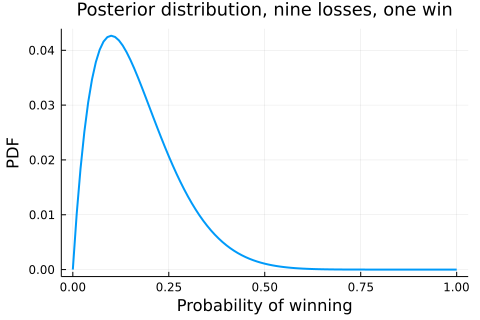

In [29]:
plot(bandit)
xlabel!("Probability of winning")
ylabel!("PDF")
title!("Posterior distribution, nine losses, one win", titlefontsize=12)

## Multiple Bandits

In [30]:
actual_probs = [0.10, 0.20, 0.30, 0.40];

In [31]:
using DataStructures: counter

# count how many times we've played each machine
count = counter(Int)

"""Play machine i.

i: index of the machine to play

returns: string 'W' or 'L'
"""
function play(i)
    global count[i] += 1
    p = actual_probs[i]
    return (rand() < p) ? 'W' : 'L'
end

play

In [32]:
for i in 1:4
    for _ in 1:10
        outcome = play(i)
        update!(beliefs[i], outcome)
    end
end

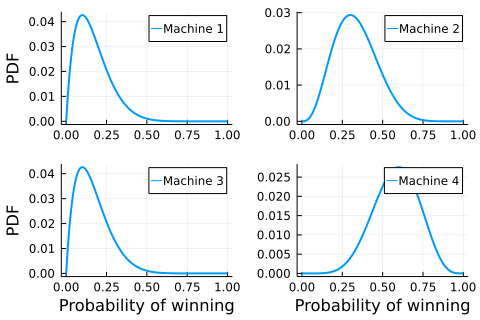

In [33]:
plot_beliefs(beliefs)

In [34]:
using DataFrames
using Statistics

"""Compute means and credible intervals.

beliefs: sequence of Pmf

returns: DataFrame
"""
function summarize_beliefs(beliefs)
    columns = ["Actual P(win)", 
               "Posterior mean", 
               "Credible interval"]
    
    df = DataFrame([c => [] for c in columns])
    for (a, b) in zip(actual_probs, beliefs)
        m = round(mean(b), digits=3)
        ci = credibleinterval(b, 0.9)
        ci = round.(ci, digits=3)
        push!(df, (a, m, ci))
    end
    return df
end

summarize_beliefs

In [35]:
summarize_beliefs(beliefs)

,Actual P(win),Posterior mean,Credible interval
,Any,Any,Any
1,0.1,0.167,"[0.03, 0.36]"
2,0.2,0.333,"[0.14, 0.56]"
3,0.3,0.167,"[0.03, 0.36]"
4,0.4,0.583,"[0.35, 0.8]"


## Explore and Exploit

In [36]:
samples = hcat([sample(b, 1000) for b in beliefs]...)
size(samples)

(1000, 4)

In [37]:
indices = mapslices(argmax, samples, dims=2);

In [38]:
pmf = pmffromseq(indices)

┌───┬───────┐
│   │ probs │
├───┼───────┤
│ 1 │ 0.006 │
│ 2 │ 0.109 │
│ 3 │ 0.008 │
│ 4 │ 0.877 │
└───┴───────┘


In [39]:
sample(pmf)

4

In [40]:
"""Use Thompson sampling to choose a machine.

Draws a single sample from each distribution.

returns: index of the machine that yielded the highest value
"""
function choose(beliefs)
    ps = [sample(b) for b in beliefs]
    return argmax(ps)
end

choose

In [41]:
choose(beliefs)

4

In [42]:
"""Choose a machine, play it, and update beliefs."""
function choose_play_update!(beliefs)    
    # choose a machine
    machine = choose(beliefs)
    
    # play it
    outcome = play(machine)
    
    # update beliefs
    update!(beliefs[machine], outcome)
end

choose_play_update!

In [43]:
beliefs = [copy(prior) for i ∈ 1:4]
count = counter(Int)

Accumulator{Int64,Int64}()

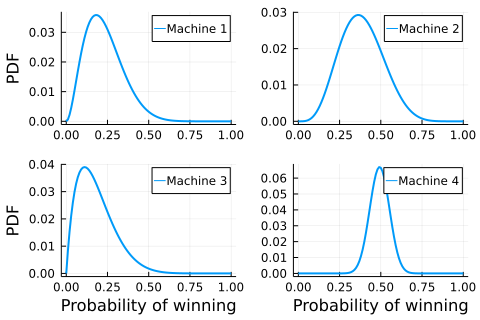

In [44]:
num_plays = 100

for i ∈ 1:num_plays
    choose_play_update!(beliefs)
end
plot_beliefs(beliefs)

In [45]:
summarize_beliefs(beliefs)

,Actual P(win),Posterior mean,Credible interval
,Any,Any,Any
1,0.1,0.231,"[0.07, 0.44]"
2,0.2,0.385,"[0.18, 0.61]"
3,0.3,0.182,"[0.04, 0.39]"
4,0.4,0.493,"[0.4, 0.59]"


In [46]:
"""Report the number of times each machine was played.

counter: Collections.Counter

returns: DataFrame
"""
function summarize_counter(counter)
    df = DataFrame("Actual P(win)" => zeros(4), "Times played" => zeros(Int, 4))
    for (i, c) in pairs(count)
        df[i, :] = (actual_probs[i], c)
    end
    return df
end

summarize_counter

In [47]:
summarize_counter(count)

,Actual P(win),Times played
,Float64,Int64
1,0.1,11
2,0.2,11
3,0.3,9
4,0.4,69


## Summary

## Exercises

## The Model

In [48]:
"""Probability of a correct response."""
function prob_correct(ability, difficulty)
    a = 100
    c = 0.25
    x = (ability .- difficulty) ./ a
    p = c .+ (1-c) ./ (1 .+ exp.(-x))
    return p
end

prob_correct

In [49]:
abilities = range(100, 900, length=50)
diff = 500
ps = prob_correct(abilities, diff);

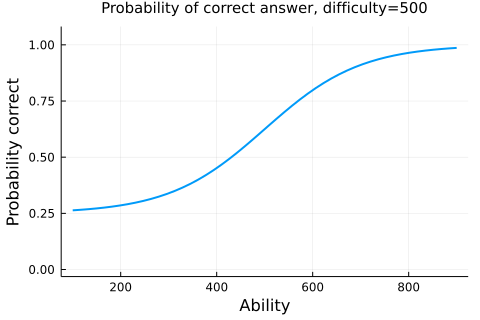

In [50]:
plot(abilities, ps, ylims=[0, 1.05], 
    xlabel="Ability", ylabel="Probability correct",
    title="Probability of correct answer, difficulty=500",
    titlefontsize=10)

## Simulating the Test

In [51]:
"""Simulate a test-taker answering a question."""
function play(ability, difficulty)
    p = prob_correct(ability, difficulty)
    return rand() < p
end

play

In [52]:
prob_correct(600, 500)

0.7982939339725037

In [53]:
import Random
Random.seed!(18)

MersenneTwister(18)

In [54]:
num_questions = 51
outcomes = [play(600, 500) for _ in 1:num_questions]
mean(outcomes)

0.8431372549019608

## The Prior

In [55]:
μ = 500
σ = 300

qs = range(0, 1000, length=50)
ps = pdf.(Normal(μ, σ), qs)

prior = Pmf(ps, qs)
normalize!(prior)

0.04464186995102338

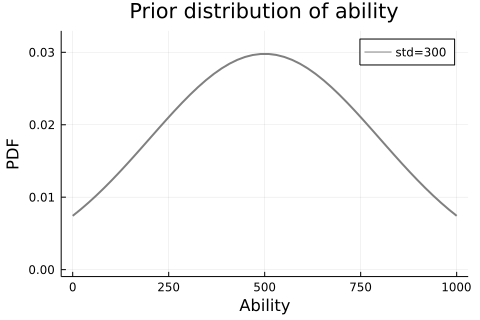

In [56]:
plot(prior, label="std=300", color=:gray, ylims=[0, 0.032], 
     xlabel="Ability", ylabel="PDF", title="Prior distribution of ability")

## The Update

In [57]:
"""Update the distribution of ability."""
function update_ability!(pmf, data)
    difficulty, outcome = data
    
    abilities = pmf.qs
    ps = prob_correct(abilities, difficulty)
    
    if outcome
        pmf .*= ps
    else
        pmf .*= 1 .- ps
    end
        
    normalize!(pmf)
end

update_ability!

In [58]:
actual_600 = copy(prior)

for outcome in outcomes
    data = (500, outcome)
    update_ability!(actual_600, data)
end

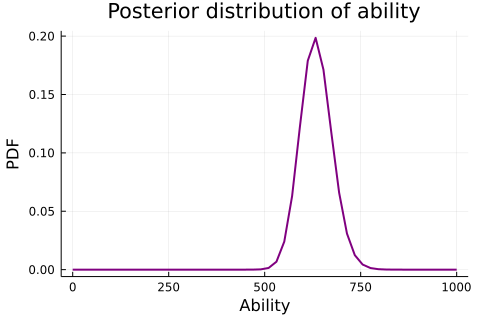

In [59]:
plot(actual_600, color=:purple, xlabel="Ability", 
     ylabel="PDF", title="Posterior distribution of ability")

In [60]:
mean(actual_600)

634.2032645376712

## Adaptation

In [61]:
"""Choose the difficulty of the next question."""
choose(i, belief) = 500

choose

In [62]:
"""Simulate a person taking a test."""
function simulate_test(actual_ability)
    belief = copy(prior)
    trace = DataFrame("difficulty" => [], "outcome" =>[])

    for i in 1:num_questions
        difficulty = choose(i, belief)
        outcome = play(actual_ability, difficulty)
        data = (difficulty, outcome)
        update_ability!(belief, data)
        push!(trace, (difficulty, outcome))
    end
    return belief, trace
end

simulate_test

In [63]:
belief, trace = simulate_test(600);

In [64]:
sum(trace[!,"outcome"])

38

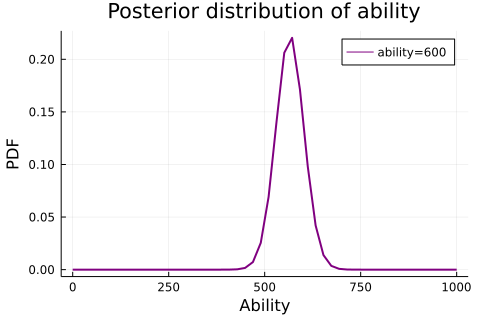

In [65]:
plot(belief, color=:purple, label="ability=600", xlabel="Ability", 
     ylabel="PDF", title="Posterior distribution of ability")

## Quantifying Precision

In [66]:
mean(belief), std(belief)

(565.880696381761, 36.89464585220902)

In [67]:
actual_abilities = range(200, 800, length=50)
results = DataFrame("ability" => [], "posterior_std" => [])
series = DataFrame(:index => actual_abilities, :std => zeros(length(actual_abilities)))

# helper to access a specific row
series_at!(s, i, v) = s[findfirst(==(i), s.index), :std] = v

for actual_ability in actual_abilities
    belief, trace = simulate_test(actual_ability)
    series_at!(series, actual_ability, std(belief))
end

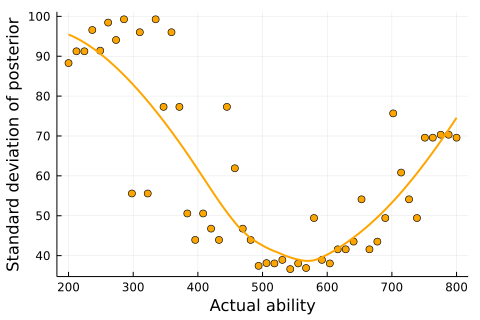

In [68]:
using StatsPlots, Loess

function plot_loess!(xs, ys; kwargs...)
    model = loess(xs, ys)
    us = range(extrema(xs)...; length = 101)
    vs = Loess.predict(model, us)
    plot!(us, vs; kwargs...)
end

@df series scatter(:index, :std, xlabel="Actual ability",
    ylabel="Standard deviation of posterior", color=:orange)
plot_loess!(series.index, series.std, color=:orange)


## Discriminatory Power

In [69]:
"""Simulate multiple tests and compute posterior means.
    
    actual_ability: number
    iters: number of simulated tests
    
    returns: array of scores
"""
function sample_posterior(actual_ability; iters)
    scores = []

    for i in 1:iters
        belief, trace = simulate_test(actual_ability)
        score = mean(belief)
        push!(scores, score)
    end 
    return scores
end

sample_posterior

In [70]:
sample_500 = sample_posterior(500, iters=100);

In [71]:
sample_600 = sample_posterior(600, iters=100);

In [72]:
sample_700 = sample_posterior(700, iters=100);

In [73]:
sample_800 = sample_posterior(800, iters=100);

In [74]:
cdf_500 = cdffromseq(sample_500)
cdf_600 = cdffromseq(sample_600)
cdf_700 = cdffromseq(sample_700)
cdf_800 = cdffromseq(sample_800);

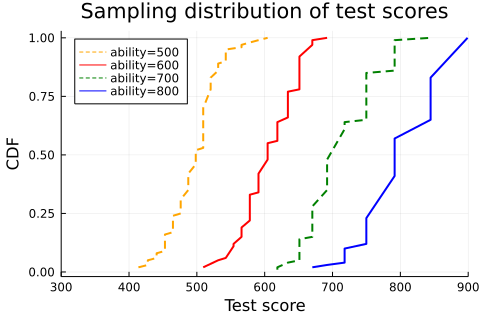

In [75]:
plot(cdf_500, label="ability=500", color=:orange,
            linestyle=:dash)
plot!(cdf_600, label="ability=600", color=:red)
plot!(cdf_700, label="ability=700", color=:green,
            linestyle=:dash)
plot!(cdf_800, label="ability=800", color=:blue, legend=:topleft)

xlabel!("Test score")
ylabel!("CDF")
title!("Sampling distribution of test scores")
xlims!(300, 900)

In [76]:
mean(sample_600 .> sample_500)

0.99

In [77]:
mean(sample_700 .> sample_600)

0.9

In [78]:
mean(sample_800 .> sample_700)

0.84

In [79]:
num_questions = 51
difficulties = range(200, 800, length=num_questions)
"""Choose the difficulty of the next question.

i: index from [0..num_questions-1]
belief: Pmf representing current estimate of ability

returns: difficulty
"""
choose(i, belief) = difficulties[i]

choose

In [80]:
"""Choose the difficulty of the next question.

i: index from [0..num_questions-1]
belief: Pmf representing current estimate of ability

returns: difficulty
"""
choose(i, belief) = mean(belief)

choose